Author: Emily Wong \
February 16, 2023

# Resources

https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-for-ensemble-models/#4

https://towardsdatascience.com/having-an-imbalanced-dataset-here-is-how-you-can-solve-it-1640568947eb

https://neptune.ai/blog/cross-validation-mistakes

# 1. Import libraries, methods, and data

## 1.1. Libraries

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Data wrangling
import pandas as pd
import numpy as np
from numpy.random import uniform, normal, seed

# Machine learning
import sklearn
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, roc_auc_score, balanced_accuracy_score
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, RandomizedSearchCV, GridSearchCV, train_test_split
from sklearn.inspection import permutation_importance
import scipy
from scipy.stats import randint
import xgboost as xgb
from imblearn.over_sampling import SMOTENC, RandomOverSampler, SMOTE
from imblearn.under_sampling import TomekLinks, NeighbourhoodCleaningRule, EditedNearestNeighbours, RandomUnderSampler
from imblearn.combine import SMOTEENN, SMOTETomek
import optuna
import joblib

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import matplotlib.pyplot as plt
import seaborn as sns # for kernel density plots

# for nested dictionary
import collections
def makehash():
    return collections.defaultdict(makehash)

# Fairness
import aif360
import fairlearn
from fairlearn.metrics import demographic_parity_difference, demographic_parity_ratio, equalized_odds_difference, equalized_odds_ratio, false_negative_rate

The __demographic parity difference__ of 0 means that all groups have the same selection rate. For multiple groups, average across all pairwise differences. Ranges between 0 and 1.

The __demographic parity ratio__ of 1 means that all groups have the same selection rate.

The __equalized odds difference__ of 0 means that all groups have the same true positive, true negative, false positive, and false negative rates.

The __equalized odds ratio__ of 1 means that all groups have the same true positive, true negative, false positive, and false negative rates.

## 1.2 Reweighing Method

In [2]:
def calc_weights(df, sens_features_name, outcome_name):
    ''' Calculate sample weights according to calculationg given in 
           F. Kamiran and T. Calders,  "Data Preprocessing Techniques for
           Classification without Discrimination," Knowledge and Information
           Systems, 2012.
    ''' 
    
    # combination of label and groups (outputs a table)
    sens_features = df[sens_features_name]
    outcome = df[outcome_name]
    tab = pd.DataFrame(pd.crosstab(index=sens_features, columns=outcome))

    # reweighing weights
    w = makehash()
    n = len(df)
    for r in tab.index:
        key1 = str(r)
        row_sum = tab.loc[r].sum(axis=0)
        for c in tab.columns:
            key2 = str(c)
            col_sum = tab[c].sum()
            if tab.loc[r,c] == 0:
                n_combo = 1
            else:
                n_combo = tab.loc[r,c]
            val = (row_sum*col_sum)/(n*n_combo)
            w[key1][key2] = val
    
    # Instance weights
    instance_weights = []
    for index, row in df.iterrows():
        race = row[sens_features_name]
        out = row[outcome_name]
        instance_weights.append(w[race][str(out)])

    return instance_weights

In [3]:
def display_performance(X_train, y_train, X_test, y_test, model):
    # Train performance
    y_train_pred = model.predict(X_train)
    print("Train Accuracy:", np.round(accuracy_score(y_train, y_train_pred),5))
    print("Train Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_train, y_train_pred),5))
    cm = confusion_matrix(y_train, y_train_pred)
    print("Train Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

    print("")

    # Test performance
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", np.round(test_accuracy,5))
    print("Test Balanced Acc:",np.round(sklearn.metrics.balanced_accuracy_score(y_test, y_pred),5))
    cm = confusion_matrix(y_test, y_pred)
    print("Test Confusion Matrix:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);

In [4]:
def optim_thresh(X_test, y_test, model):
    # Find optimal threshold
    step_factor = 0.05 
    threshold_value = 0.05
    roc_score=0
    predicted_proba = model.predict_proba(X_test) #probability of prediction
    while threshold_value <=0.8: #continue to check best threshold upto probability 0.8
        temp_thresh = threshold_value
        predicted = (predicted_proba [:,1] >= temp_thresh).astype('int') #change the class boundary for prediction
        if roc_score<roc_auc_score(y_test, predicted, multi_class='ovo'): #store the threshold for best classification
            roc_score = roc_auc_score(y_test, predicted)
            thrsh_score = threshold_value
        threshold_value = threshold_value + step_factor
    print('---Optimum Threshold ---',np.round(thrsh_score,5),'--ROC--',np.round(roc_score,5))

    optim_thresh = thrsh_score
    y_pred_optim = (predicted_proba [:,1] >= optim_thresh).astype('int')
    print("Optimal Test Accuracy:",np.round(accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test Balanced Accuracy:",np.round(balanced_accuracy_score(y_test, y_pred_optim),5))
    print("Optimal Test AUC:",np.round(sklearn.metrics.roc_auc_score(y_test, y_pred_optim, multi_class='ovo'),5))

    # Create the confusion matrix
    cm = confusion_matrix(y_test, y_pred_optim)
    print("Test Confusion Matrix w/ Optimal Threshold:")
    print(cm)
    ConfusionMatrixDisplay(confusion_matrix=cm).plot(cmap=plt.cm.Greens);
    
    return thrsh_score
    

## 1.3. Data

In [5]:
all_data = pd.read_excel("Eynav cleaned data.xlsx")

In [6]:
print(all_data.shape)

(19790, 43)


In [7]:
print(all_data.columns)

Index(['DELIVERY_TIME', 'MOM_PAT_ID', 'FINANCIAL_CLASS', 'PRIMARY_PAYOR_NAME',
       'MARITAL_STATUS', 'ZIP', 'MOM_AGE', 'MOM_RACE', 'ETHNIC_GROUP',
       'CHILD_BIRTH_WT', 'LBW', 'CHILD_GESTATION_AGE_NUMBER', 'PTB',
       'DELIVERY_METHOD', 'NOTE_SW', 'NICU_ADMIT', 'MFCU_ADMIT', 'GRAVIDITY',
       'PARITY', 'ABORTIONS', 'PREE', 'GDM', 'GHTN', 'MOM_BMI', 'MOM_LOS',
       'CHILD_LOS', 'HISTORIC_DX_LIST', 'MED_PSYCH', 'MED_CARDIO', 'ANSWER11',
       'PHQ9_VALUE', 'EPDSANSWER10', 'TOTAL_EPDS_VALUE',
       'MENTAL_HEALTH_DX_CUTOFF', 'HIST_ANXIETY', 'HIST_DEPRESS',
       'HIST_BIPOLAR', 'HIST_PMAD', 'EPDS_risk', 'EPDS_risk2', 'PHQ9_risk',
       'PHQ9_risk2', 'PMAD_risk'],
      dtype='object')


This below chuck is only for reporting demographic information in manuscript:

In [8]:
demo = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','ZIP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO','PMAD_risk']]
demo = demo.dropna()            # keep only complete data (for now)
demo = demo.sample(len(demo))   # randomly shuffle rows
demo.shape

print("Min Age:",min(demo['MOM_AGE']))
print("Max Age:",max(demo['MOM_AGE']))
print("Mean Age:",np.mean(demo['MOM_AGE']))
print("SD Age:",np.std(demo['MOM_AGE']))

print("------------RACE/ETHNIC COUNTS------------")
race = demo['MOM_RACE']
ethnic = demo['ETHNIC_GROUP']
print(pd.DataFrame(pd.crosstab(index=race, columns=ethnic)))

Min Age: 14.0
Max Age: 59.0
Mean Age: 34.13058472308009
SD Age: 4.861398430101026
------------RACE/ETHNIC COUNTS------------
ETHNIC_GROUP                                        Hispanic  Non-Hispanic  \
MOM_RACE                                                                     
Asian or Native Hawaiian or Other Pacific Islander        21          2330   
Black or African American                                 53          1346   
Hispanic White                                          1842             0   
Multiracial                                              140           420   
Other                                                   1000          1113   
Unknown                                                   33            40   
White                                                      0         10855   

ETHNIC_GROUP                                        Unknown  
MOM_RACE                                                     
Asian or Native Hawaiian or Other Pacific Island

In [9]:
print(demo.shape)

(19428, 25)


Extract relevant variables for model fitting:

In [10]:
outcome = 'EPDS_risk2'

data = all_data[['MOM_AGE','MOM_RACE','ETHNIC_GROUP','ZIP','MARITAL_STATUS','FINANCIAL_CLASS',
                 'LBW','PTB',
                 'DELIVERY_METHOD','NICU_ADMIT','MFCU_ADMIT',
                 'PREE','GDM','GHTN',
                 'MOM_BMI','MOM_LOS','CHILD_LOS',
                 'HIST_ANXIETY','HIST_DEPRESS','HIST_BIPOLAR','HIST_PMAD','MENTAL_HEALTH_DX_CUTOFF',
                 'MED_PSYCH','MED_CARDIO',
                 outcome,'TOTAL_EPDS_VALUE']]

## 1.3.3. Curate Data

In [11]:
data = data.dropna()            # keep only complete data (for now)
data = data.sample(len(data))   # randomly shuffle rows
data.shape

(8658, 26)

In [12]:
scale_data = data[['MOM_RACE','ETHNIC_GROUP','TOTAL_EPDS_VALUE','EPDS_risk2']]

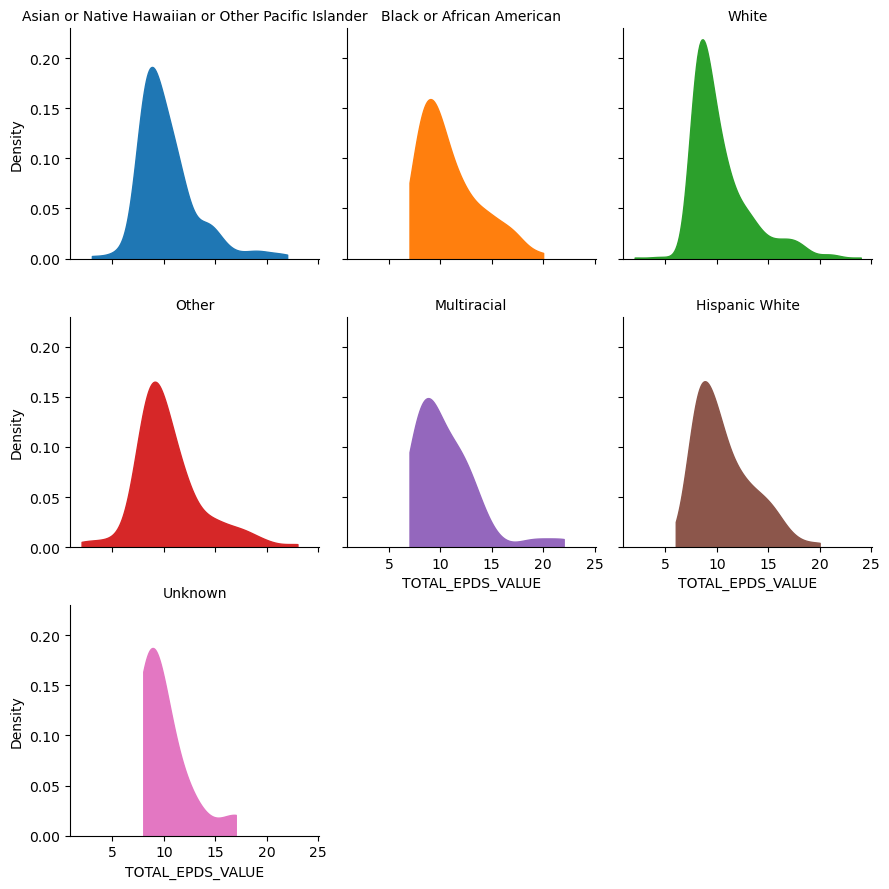

In [13]:
scale_data2 = scale_data[scale_data.EPDS_risk2==1]

# create a grid 
g = sns.FacetGrid(scale_data2, col='MOM_RACE', hue='MOM_RACE', col_wrap=3)

# draw density plots
g = g.map(sns.kdeplot,"TOTAL_EPDS_VALUE", cut=0, fill=True, common_norm=False, alpha=1, legend=False)

# control the title of each facet
g = g.set_titles("{col_name}")

# show the graph
#plt.show()

plt.savefig('Figure 2.png',dpi=600)

In [14]:
data = data.drop(['TOTAL_EPDS_VALUE'], axis=1)

In [15]:
race = data['MOM_RACE']
ethnic = data['ETHNIC_GROUP']
out = data[outcome]

print("------------MEDIAN AGE------------")
print(pd.crosstab(index=race, columns=ethnic, values=data['MOM_AGE'], aggfunc=np.median))
print("Overall median age:",np.median(data[['MOM_AGE']]))

print("------------RACE/ETHNIC COUNTS------------")
print(pd.DataFrame(pd.crosstab(index=race, columns=ethnic)))

print("------------RACE/ETHNIC PMAD------------")
print(pd.crosstab(index=[ethnic,race], columns=out, normalize='index'))

print("Overall PMAD:",np.mean(data[[outcome]]))

------------MEDIAN AGE------------
ETHNIC_GROUP                                        Hispanic  Non-Hispanic  \
MOM_RACE                                                                     
Asian or Native Hawaiian or Other Pacific Islander      36.0          35.0   
Black or African American                               31.0          33.0   
Hispanic White                                          33.0           NaN   
Multiracial                                             34.0          35.0   
Other                                                   33.0          35.0   
Unknown                                                 31.0          33.0   
White                                                    NaN          35.0   

ETHNIC_GROUP                                        Unknown  
MOM_RACE                                                     
Asian or Native Hawaiian or Other Pacific Islander     34.0  
Black or African American                              34.0  
Hispanic White

7662 996


<BarContainer object of 2 artists>

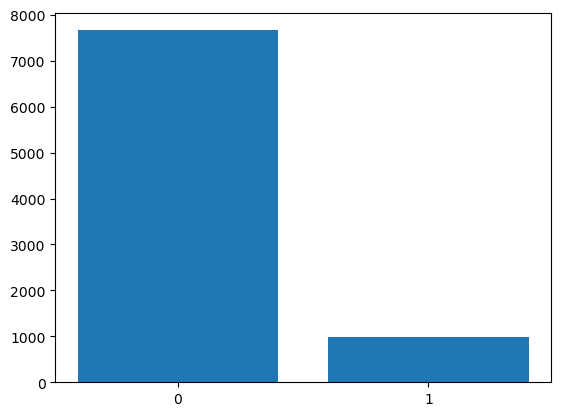

In [16]:
# binary-class
count0, count1 = data[outcome].value_counts()
print(count0, count1)

x = ['0','1']
y = [count0, count1]
plt.bar(x, y)

In [17]:
print("N:",data.shape)

N: (8658, 25)


## 1.3.4. Weight Data

In [18]:
data['w'] = calc_weights(df=data, sens_features_name="MOM_RACE", outcome_name=outcome)

In [19]:
data[['w',outcome,'MOM_RACE']].drop_duplicates()

,w,EPDS_risk2,MOM_RACE
502,1.018421,0.0,Black or African American
16902,0.983454,0.0,White
17159,1.009998,0.0,Hispanic White
17021,0.993972,0.0,Other
6889,1.061360,0.0,Asian or Native Hawaiian or Other Pacific Isla...
16122,0.992671,0.0,Multiracial
9011,0.692168,1.0,Asian or Native Hawaiian or Other Pacific Isla...
18840,0.877850,1.0,Black or African American
3836,1.148671,1.0,White
17622,1.048938,1.0,Other


## 1.3.5. Get Dummies and Split

In [20]:
# get dummy variables
data = pd.get_dummies(data)

Split data. Can specify whether to use stratify sampling or not.

In [21]:
# split into X and y
X = data.drop([outcome], axis=1)
y = data[[outcome]]

race = data[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
             'MOM_RACE_Black or African American',
             'MOM_RACE_Multiracial',
             'MOM_RACE_Other',
             'MOM_RACE_Unknown',
             'MOM_RACE_White',
             'MOM_RACE_Hispanic White']]
strat_df = pd.concat([y,race],axis=1)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, test_size=0.15, shuffle=True, stratify=strat_df, random_state=0)
X_test = X_test.drop(['w'], axis=1)

# Sensitive features
race_feature = X_test[['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
                       'MOM_RACE_Black or African American',
                       'MOM_RACE_Multiracial',
                       'MOM_RACE_Other',
                       'MOM_RACE_Unknown',
                       'MOM_RACE_White',
                       'MOM_RACE_Hispanic White']]

In [22]:
# binary-class
count0_train, count1_train = y_train.value_counts()
print(count0_train, count1_train)

count0_test, count1_test = y_test.value_counts()
print(count0_test, count1_test)

6512 847
1150 149


# 2. Handle imbalanced data

## 2.1. Simple Over Sampling Minority (PMAD)

In [23]:
ros = RandomOverSampler(sampling_strategy = "auto",random_state=0)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)
weights_ros = X_train_ros['w']
X_train_ros = X_train_ros.drop(['w'], axis=1)
y_train_ros.value_counts()

EPDS_risk2
0.0           6512
1.0           6512
Name: count, dtype: int64

## 2.2. Simple Under Sampling Majority (PMAD)

In [24]:
rus = RandomUnderSampler(sampling_strategy = "auto", random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)
weights_rus = X_train_rus['w']
X_train_rus = X_train_rus.drop(['w'], axis=1)
y_train_rus.value_counts()

EPDS_risk2
0.0           847
1.0           847
Name: count, dtype: int64

# 3. Modeling

In [25]:
# Extract weights and drop from training and test data frames
weights = X_train['w']
X_train = X_train.drop(['w'], axis=1)

In [26]:
# Base group is non-Hispanic White
races = ['MOM_RACE_Asian or Native Hawaiian or Other Pacific Islander',
         'MOM_RACE_Black or African American',
         'MOM_RACE_Hispanic White',
         'MOM_RACE_Multiracial',
         'MOM_RACE_Other',
         'MOM_RACE_Unknown']

reweigh_results = []
no_reweigh_results = []

## XG Boost Classifier

https://www.kaggle.com/code/stuarthallows/using-xgboost-with-scikit-learn

### Finetune XG Boost Classifier without Reweighing

[I 2024-02-21 14:22:56,467] A new study created in memory with name: no-name-f4bf5a27-80e7-4f96-922c-19337c54b667
[I 2024-02-21 14:22:58,598] Trial 0 finished with value: 0.5811438576014006 and parameters: {'learning_rate': 0.012520653814999465, 'max_depth': 8, 'subsample': 0.6226252072680617, 'colsample_bytree': 0.567639023847052, 'min_child_weight': 9}. Best is trial 0 with value: 0.5811438576014006.
[I 2024-02-21 14:22:59,952] Trial 1 finished with value: 0.5774204843886781 and parameters: {'learning_rate': 0.019578897201213006, 'max_depth': 5, 'subsample': 0.8971843507429758, 'colsample_bytree': 0.9654796224759777, 'min_child_weight': 8}. Best is trial 0 with value: 0.5811438576014006.
[I 2024-02-21 14:23:01,243] Trial 2 finished with value: 0.55815582141815 and parameters: {'learning_rate': 0.03832216850492789, 'max_depth': 6, 'subsample': 0.5896423330392356, 'colsample_bytree': 0.9293168063780279, 'min_child_weight': 2}. Best is trial 0 with value: 0.5811438576014006.
[I 2024-02-

Test Balanced Accuracy: 0.655
---Optimum Threshold --- 0.05 --ROC-- 0.65545
Optimal Test Accuracy: 0.63818
Optimal Test Balanced Accuracy: 0.65545
Optimal Test AUC: 0.65545
Test Confusion Matrix w/ Optimal Threshold:
[[728 422]
 [ 48 101]]
AUCROC: 0.6554479136270791


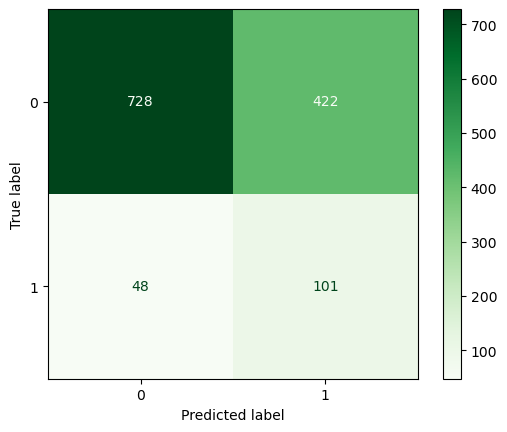

In [27]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {
        "seed":0,
        "objective": "binary:hinge",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params,random_state=0)
    model.fit(x, y, verbose=False)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

best_xgb = xgb.XGBClassifier(objective='binary:hinge',n_estimators=1000, verbosity=0, seed=0, **study.best_params)
best_xgb.fit(x,y,verbose=False)
y_pred = best_xgb.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_xgb)
y_pred_optim = pd.DataFrame((best_xgb.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])

test_set = pd.concat([y_pred_optim,y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# TP and FN
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'XGB',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [28]:
joblib.dump(best_xgb, 'best_xgb_epds_no_reweigh.pkl')

['best_xgb_epds_no_reweigh.pkl']

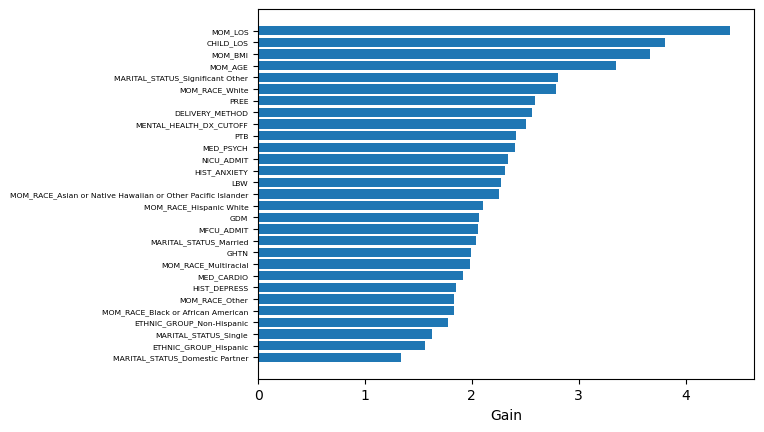

In [29]:
gain = best_xgb.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('EPDS XGB Feature Importance.png',dpi=600, bbox_inches='tight')

In [30]:
pd.DataFrame(no_reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.332712,-0.325509,0.325509
1,XGB,MOM_RACE_Black or African American,0.282702,-0.282774,0.282774
2,XGB,MOM_RACE_Hispanic White,0.189253,-0.036620,0.036620
3,XGB,MOM_RACE_Multiracial,0.234794,-0.036620,0.036620
4,XGB,MOM_RACE_Other,0.152049,-0.249120,0.249120
5,XGB,MOM_RACE_Unknown,0.105382,0.063380,-0.063380


### Finetune XG Boost Classifier with Reweighing

[I 2024-02-21 14:27:05,190] A new study created in memory with name: no-name-a5f1262f-3e00-4a29-9f7a-e9b118a3255b
[I 2024-02-21 14:27:07,024] Trial 0 finished with value: 0.5732506565509192 and parameters: {'learning_rate': 0.012520653814999465, 'max_depth': 8, 'subsample': 0.6226252072680617, 'colsample_bytree': 0.567639023847052, 'min_child_weight': 9}. Best is trial 0 with value: 0.5732506565509192.
[I 2024-02-21 14:27:08,207] Trial 1 finished with value: 0.5838079953311934 and parameters: {'learning_rate': 0.019578897201213006, 'max_depth': 5, 'subsample': 0.8971843507429758, 'colsample_bytree': 0.9654796224759777, 'min_child_weight': 8}. Best is trial 1 with value: 0.5838079953311934.
[I 2024-02-21 14:27:09,576] Trial 2 finished with value: 0.5474642544499562 and parameters: {'learning_rate': 0.03832216850492789, 'max_depth': 6, 'subsample': 0.5896423330392356, 'colsample_bytree': 0.9293168063780279, 'min_child_weight': 2}. Best is trial 1 with value: 0.5838079953311934.
[I 2024-0

Test Balanced Accuracy: 0.663
---Optimum Threshold --- 0.05 --ROC-- 0.66308
Optimal Test Accuracy: 0.66205
Optimal Test Balanced Accuracy: 0.66308
Optimal Test AUC: 0.66308
Test Confusion Matrix w/ Optimal Threshold:
[[761 389]
 [ 50  99]]
AUCROC: 0.6630843303180625


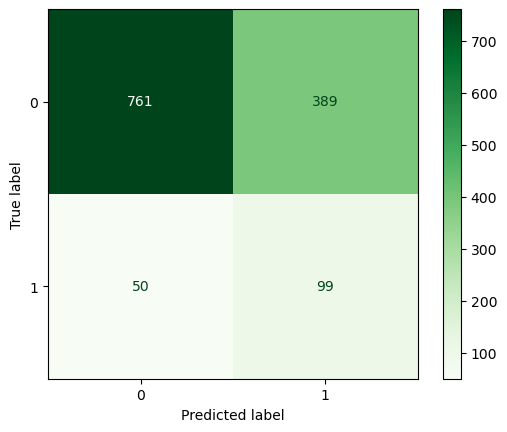

In [31]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {
        "seed":0,
        "objective": "binary:hinge",
        "n_estimators": 1000,
        "verbosity": 0,
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    }

    model = xgb.XGBClassifier(**params)
    model.fit(x, y, sample_weight=w, verbose=False)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

#optuna.logging.set_verbosity(optuna.logging.WARNING)
sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

best_xgb2 = xgb.XGBClassifier(objective='binary:hinge',n_estimators=1000, verbosity=0, seed=0, **study.best_params)
best_xgb2.fit(x,y,sample_weight=w,verbose=False)
y_pred = best_xgb2.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_xgb2)
y_pred_optim = pd.DataFrame((best_xgb2.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])

test_set = pd.concat([y_pred_optim,y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# TP and FN
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'XGB',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [32]:
joblib.dump(best_xgb2, 'best_xgb_epds_reweigh.pkl')

['best_xgb_epds_reweigh.pkl']

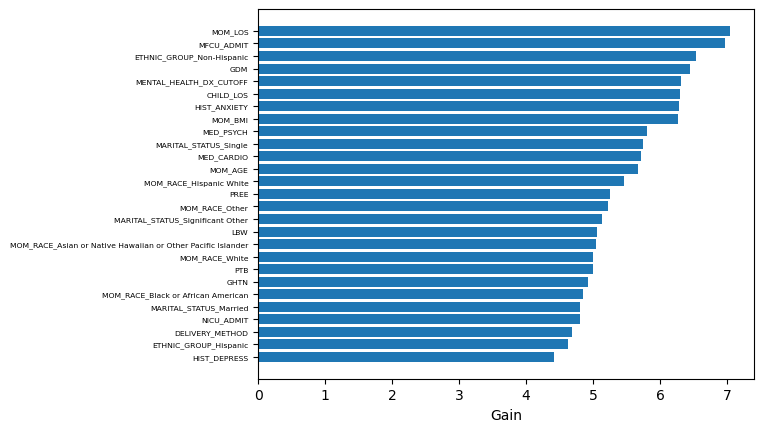

In [33]:
gain = best_xgb2.get_booster().get_score(importance_type='gain')
gain_sorted = dict(sorted(gain.items(), key=lambda x: x[1], reverse=False))

features = list(gain_sorted.keys())
values = list(gain_sorted.values())

fig, ax = plt.subplots()
ax.barh(features,values)
plt.yticks(fontsize=5.5)
ax.set_xlabel("Gain")
plt.savefig('EPDS XGB Feature Importance Reweigh.png',dpi=600, bbox_inches='tight')

In [34]:
pd.DataFrame(reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.057898,0.004173,-0.004173
1,XGB,MOM_RACE_Black or African American,0.157341,-0.135428,0.135428
2,XGB,MOM_RACE_Hispanic White,0.076030,0.033803,-0.033803
3,XGB,MOM_RACE_Multiracial,0.163001,0.033803,-0.033803
4,XGB,MOM_RACE_Other,0.132805,-0.241197,0.241197
5,XGB,MOM_RACE_Unknown,0.072805,0.133803,-0.133803


## Random Forest

### Finetune Random Forest without Reweighing

[I 2024-02-21 14:31:04,945] A new study created in memory with name: no-name-50febef3-1c36-4abf-9df4-591f695ff3d7
[I 2024-02-21 14:31:04,970] Trial 0 finished with value: 0.5968398015757221 and parameters: {'random_state': 27, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 12, 'max_depth': 14}. Best is trial 0 with value: 0.5968398015757221.
[I 2024-02-21 14:31:04,996] Trial 1 finished with value: 0.6074204843886781 and parameters: {'random_state': 32, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 20, 'max_depth': 13}. Best is trial 1 with value: 0.6074204843886781.
[I 2024-02-21 14:31:05,025] Trial 2 finished with value: 0.6136299970819958 and parameters: {'random_state': 40, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 19, 'max_depth': 3}. Best is trial 2 with value: 0.6136299970819958.
[I 2024-02-21 14:31:05,070] Trial 3 finished with value: 0.6302305223227312 and parameters: {'random_state': 4, 'min_samples_leaf': 2, 'min_sam

Best hyperparameters: {'random_state': 30, 'min_samples_leaf': 11, 'min_samples_split': 50, 'n_estimators': 11, 'max_depth': 17}
Best Balanced Accuracy: 0.6433411146775605
Test Balanced Accuracy: 0.643
---Optimum Threshold --- 0.5 --ROC-- 0.64334
Optimal Test Accuracy: 0.60123
Optimal Test Balanced Accuracy: 0.64334
Optimal Test AUC: 0.64334
Test Confusion Matrix w/ Optimal Threshold:
[[677 473]
 [ 45 104]]
AUCROC: 0.6433411146775605


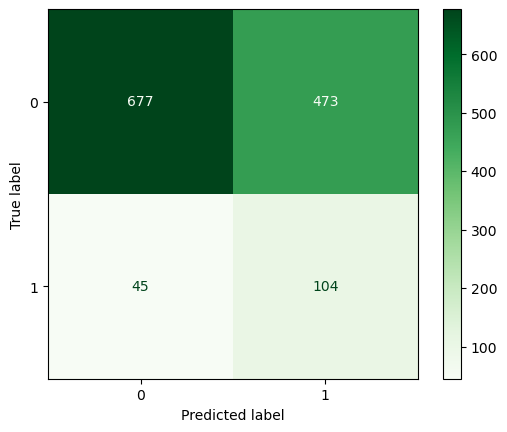

In [35]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'random_state':trial.suggest_int('random_state', 0, 50),
             'max_features':'sqrt',
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 2, 20),
             'max_depth': trial.suggest_int('max_depth', 1, 32)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

print('Best hyperparameters:', study.best_params)
print('Best Balanced Accuracy:', study.best_value)

best_rf = RandomForestClassifier(max_features='sqrt',**study.best_params)
best_rf.fit(x,y)
y_pred = best_rf.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_rf)
y_pred_optim = pd.DataFrame((best_rf.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'RF',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [36]:
joblib.dump(best_rf, 'best_rf_epds_no_reweigh.pkl')

['best_rf_epds_no_reweigh.pkl']

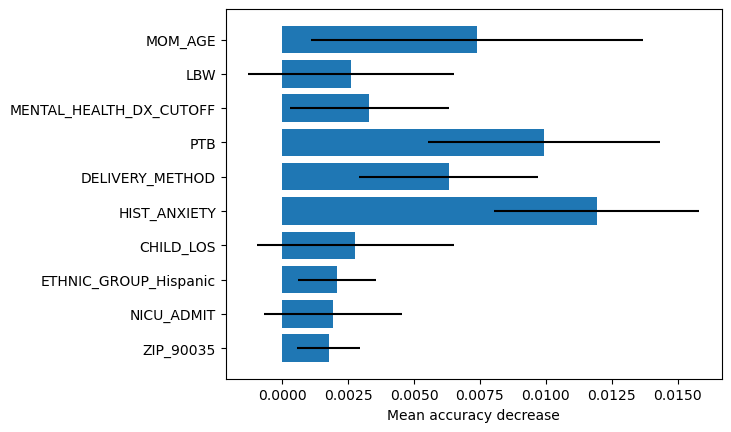

In [37]:
result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = result.importances_mean
importance_sd = result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('PHQ-9 RF Feature Importance.png',dpi=600, bbox_inches='tight')

In [38]:
pd.DataFrame(no_reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.332712,-0.325509,0.325509
1,XGB,MOM_RACE_Black or African American,0.282702,-0.282774,0.282774
2,XGB,MOM_RACE_Hispanic White,0.189253,-0.036620,0.036620
3,XGB,MOM_RACE_Multiracial,0.234794,-0.036620,0.036620
4,XGB,MOM_RACE_Other,0.152049,-0.249120,0.249120
5,XGB,MOM_RACE_Unknown,0.105382,0.063380,-0.063380
6,RF,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.220154,-0.172144,0.172144
7,RF,MOM_RACE_Black or African American,0.298210,-0.240520,0.240520
8,RF,MOM_RACE_Hispanic White,0.124532,-0.127700,0.127700
9,RF,MOM_RACE_Multiracial,0.354608,-0.394366,0.394366


### Finetune Random Forest with Reweighing

[I 2024-02-21 14:31:22,660] A new study created in memory with name: no-name-db81610d-f01f-4fcf-afed-2b24bd2144ad
[I 2024-02-21 14:31:22,686] Trial 0 finished with value: 0.5911876276626787 and parameters: {'random_state': 27, 'min_samples_leaf': 36, 'min_samples_split': 31, 'n_estimators': 12, 'max_depth': 14}. Best is trial 0 with value: 0.5911876276626787.
[I 2024-02-21 14:31:22,714] Trial 1 finished with value: 0.6061715786402101 and parameters: {'random_state': 32, 'min_samples_leaf': 22, 'min_samples_split': 45, 'n_estimators': 20, 'max_depth': 13}. Best is trial 1 with value: 0.6061715786402101.
[I 2024-02-21 14:31:22,742] Trial 2 finished with value: 0.6114677560548585 and parameters: {'random_state': 40, 'min_samples_leaf': 27, 'min_samples_split': 29, 'n_estimators': 19, 'max_depth': 3}. Best is trial 2 with value: 0.6114677560548585.
[I 2024-02-21 14:31:22,779] Trial 3 finished with value: 0.6216574263203969 and parameters: {'random_state': 4, 'min_samples_leaf': 2, 'min_sam

Best hyperparameters: {'random_state': 19, 'min_samples_leaf': 50, 'min_samples_split': 35, 'n_estimators': 20, 'max_depth': 25}
Best Balanced Accuracy: 0.6483133936387511
Test Balanced Accuracy: 0.648
---Optimum Threshold --- 0.5 --ROC-- 0.64831
Optimal Test Accuracy: 0.59969
Optimal Test Balanced Accuracy: 0.64831
Optimal Test AUC: 0.64831
Test Confusion Matrix w/ Optimal Threshold:
[[673 477]
 [ 43 106]]
AUCROC: 0.6483133936387511


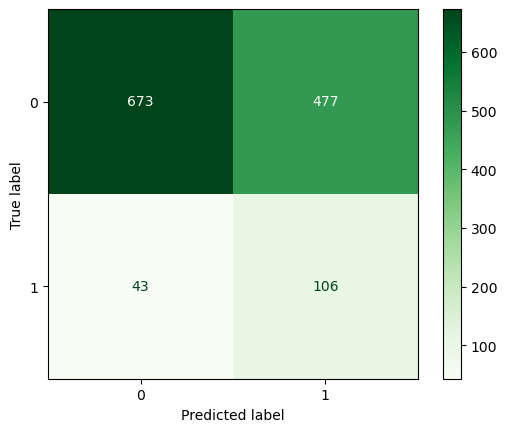

In [39]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'random_state':trial.suggest_int('random_state', 0, 50),
             'max_features':'sqrt',
             'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
             'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
             'n_estimators': trial.suggest_int('n_estimators', 2, 20),
             'max_depth': trial.suggest_int('max_depth', 1, 32)
             }
    model = RandomForestClassifier(**params)
    model.fit(x, y, sample_weight=w)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

print('Best hyperparameters:', study.best_params)
print('Best Balanced Accuracy:', study.best_value)

best_rf2 = RandomForestClassifier(max_features='sqrt',**study.best_params)
best_rf2.fit(x,y,sample_weight=w)
y_pred = best_rf2.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_rf2)
y_pred_optim = pd.DataFrame((best_rf2.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'RF',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [40]:
joblib.dump(best_rf, 'best_rf_epds_reweigh.pkl')

['best_rf_epds_reweigh.pkl']

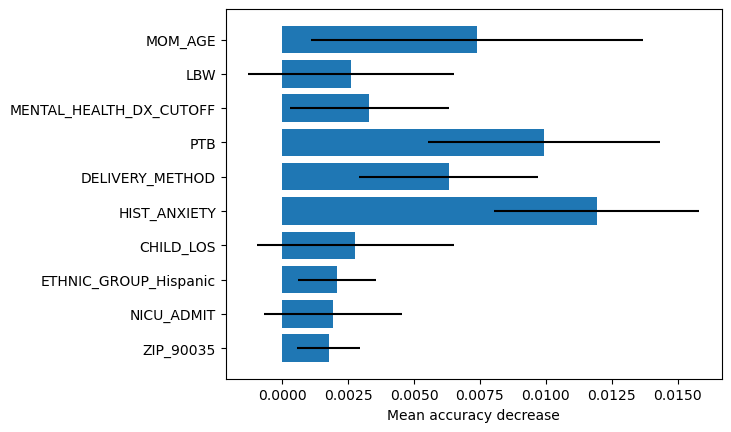

In [41]:
result = permutation_importance(
    best_rf, X_test, y_test, n_repeats=10, random_state=2024, n_jobs=2
)

importance_mean = result.importances_mean
importance_sd = result.importances_std

ind = np.argpartition(importance_mean, -10)[-10:]
top_feat = X_test.columns[ind]
top_vals = importance_mean[ind]
top_std = importance_sd[ind]

fig, ax = plt.subplots()
ax.barh(top_feat,top_vals,xerr=top_std)
ax.set_xlabel("Mean accuracy decrease")
plt.savefig('PHQ-9 RF Feature Importance Reweigh.png',dpi=600, bbox_inches='tight')

In [42]:
pd.DataFrame(reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.057898,0.004173,-0.004173
1,XGB,MOM_RACE_Black or African American,0.157341,-0.135428,0.135428
2,XGB,MOM_RACE_Hispanic White,0.076030,0.033803,-0.033803
3,XGB,MOM_RACE_Multiracial,0.163001,0.033803,-0.033803
4,XGB,MOM_RACE_Other,0.132805,-0.241197,0.241197
5,XGB,MOM_RACE_Unknown,0.072805,0.133803,-0.133803
6,RF,MOM_RACE_Asian or Native Hawaiian or Other Pac...,-0.008015,0.088680,-0.088680
7,RF,MOM_RACE_Black or African American,0.035528,-0.050921,0.050921
8,RF,MOM_RACE_Hispanic White,-0.021589,0.118310,-0.118310
9,RF,MOM_RACE_Multiracial,0.021580,0.118310,-0.118310


## Logistic Regression

### Finetune Logistic Regression without Reweighing

[I 2024-02-21 14:31:39,785] A new study created in memory with name: no-name-7a498e7d-83b3-41fa-b914-bbc24b3b2a39
[I 2024-02-21 14:31:40,179] Trial 0 finished with value: 0.6008316311642836 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.6008316311642836.
[I 2024-02-21 14:31:40,456] Trial 1 finished with value: 0.6037525532535746 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 1 with value: 0.6037525532535746.
[I 2024-02-21 14:31:40,741] Trial 2 finished with value: 0.5904522906332068 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 1 with value: 0.6037525532535746.
[I 2024-02-21 14:31:40,886] Trial 3 finished with value: 0.6009541873358624 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 1 with value: 0.6037525532535746.
[I 2024-02-21 14:31:41,006] Trial 4 finished with value: 0.5790253866355413 and parameters: {'C':

Best hyperparameters: {'C': 0.037022144983025425, 'tol': 0.00014954169643105854}
Best Balanced Accuracy: 0.6134403268164575
Test Balanced Accuracy: 0.613
---Optimum Threshold --- 0.5 --ROC-- 0.61344
Optimal Test Accuracy: 0.62587
Optimal Test Balanced Accuracy: 0.61344
Optimal Test AUC: 0.61344
Test Confusion Matrix w/ Optimal Threshold:
[[724 426]
 [ 60  89]]
AUCROC: 0.6134403268164577


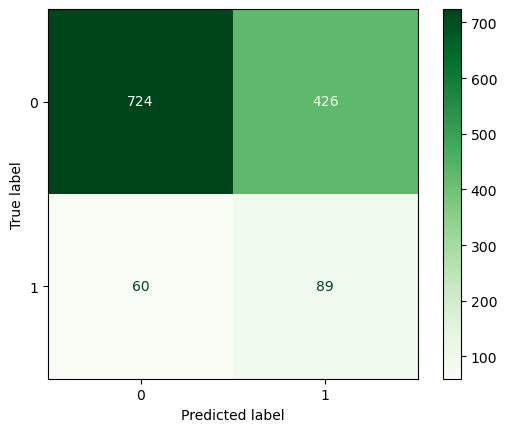

In [43]:
x = X_train_rus
y = y_train_rus.values.ravel()

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x,y)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

print('Best hyperparameters:', study.best_params)
print('Best Balanced Accuracy:', study.best_value)

best_glm = LogisticRegression(penalty='l2',**study.best_params)
best_glm.fit(x,y)
y_pred = best_glm.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_glm)
y_pred_optim = pd.DataFrame((best_glm.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    no_reweigh_results.append({'Model':'LR',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [44]:
joblib.dump(best_glm, 'best_glm_epds_no_reweigh.pkl')

['best_glm_epds_no_reweigh.pkl']

In [45]:
pd.DataFrame(no_reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.332712,-0.325509,0.325509
1,XGB,MOM_RACE_Black or African American,0.282702,-0.282774,0.282774
2,XGB,MOM_RACE_Hispanic White,0.189253,-0.036620,0.036620
3,XGB,MOM_RACE_Multiracial,0.234794,-0.036620,0.036620
4,XGB,MOM_RACE_Other,0.152049,-0.249120,0.249120
5,XGB,MOM_RACE_Unknown,0.105382,0.063380,-0.063380
6,RF,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.220154,-0.172144,0.172144
7,RF,MOM_RACE_Black or African American,0.298210,-0.240520,0.240520
8,RF,MOM_RACE_Hispanic White,0.124532,-0.127700,0.127700
9,RF,MOM_RACE_Multiracial,0.354608,-0.394366,0.394366


### Finetune Logistic Regression with Reweighing

[I 2024-02-21 14:32:24,523] A new study created in memory with name: no-name-54e3527f-6931-4f98-a55b-a5af5a8bb09b
[I 2024-02-21 14:32:24,853] Trial 0 finished with value: 0.5903297344616283 and parameters: {'C': 0.12520653814999466, 'tol': 0.0007154741770060471}. Best is trial 0 with value: 0.5903297344616283.
[I 2024-02-21 14:32:25,018] Trial 1 finished with value: 0.5915115261161366 and parameters: {'C': 0.16051911333587626, 'tol': 0.0005453382998139}. Best is trial 1 with value: 0.5915115261161366.
[I 2024-02-21 14:32:25,184] Trial 2 finished with value: 0.6003297344616283 and parameters: {'C': 0.07035737028722149, 'tol': 0.0006462482189535895}. Best is trial 2 with value: 0.6003297344616283.
[I 2024-02-21 14:32:25,330] Trial 3 finished with value: 0.596539247154946 and parameters: {'C': 0.07501954443620121, 'tol': 0.0008918812277812978}. Best is trial 2 with value: 0.6003297344616283.
[I 2024-02-21 14:32:25,484] Trial 4 finished with value: 0.5715669681937554 and parameters: {'C': 

Best hyperparameters: {'C': 0.028655323362807322, 'tol': 0.0005664454044004751}
Best Balanced Accuracy: 0.6224482054274876
Test Balanced Accuracy: 0.622
---Optimum Threshold --- 0.5 --ROC-- 0.62245
Optimal Test Accuracy: 0.63664
Optimal Test Balanced Accuracy: 0.62245
Optimal Test AUC: 0.62245
Test Confusion Matrix w/ Optimal Threshold:
[[737 413]
 [ 59  90]]
AUCROC: 0.6224482054274876


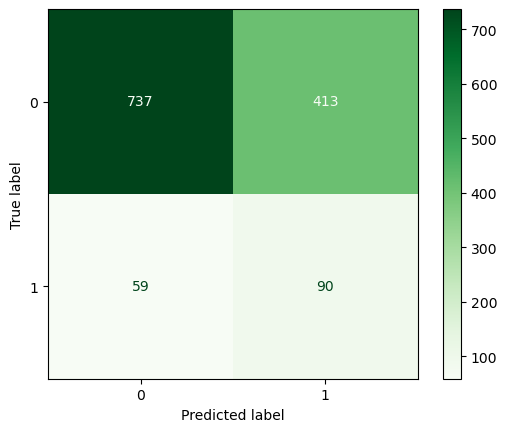

In [46]:
x = X_train_rus
y = y_train_rus.values.ravel()
w = weights_rus

def objective(trial):
    params = {'penalty':'l2',
             'C':trial.suggest_loguniform("C", 1e-2, 1),
             'tol':trial.suggest_uniform('tol' , 1e-6 , 1e-3)
             }
    model = LogisticRegression(**params)
    model.fit(x, y, sample_weight=w)
    predictions = model.predict(X_test)
    BA = balanced_accuracy_score(y_test, predictions)
    return BA

sampler = optuna.samplers.TPESampler(seed=0) 
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=250)

print('Best hyperparameters:', study.best_params)
print('Best Balanced Accuracy:', study.best_value)

best_glm = LogisticRegression(penalty='l2',**study.best_params)
best_glm.fit(x,y,sample_weight=w)
y_pred = best_glm.predict(X_test)
test_balanced_acc = sklearn.metrics.balanced_accuracy_score(y_test,y_pred)
print('Test Balanced Accuracy:', np.round(test_balanced_acc,3))

optim_threshold = optim_thresh(X_test=X_test, y_test=y_test, model=best_glm)
y_pred_optim = pd.DataFrame((best_glm.predict_proba(X_test)[:,1] >= optim_threshold).astype('int'),columns=['y_pred'])
test_set = pd.concat([pd.DataFrame(y_pred_optim),y_test.reset_index(drop=True),X_test.reset_index(drop=True)],axis=1)

# Demographic parity
p_white = np.mean(test_set['y_pred'][test_set['MOM_RACE_White']==1])

# Equalized odds
pos_lab_set_white = test_set[(test_set[outcome]==1) & (test_set['MOM_RACE_White']==1)]
pos_lab_set_white['fn'] = np.where(pos_lab_set_white['y_pred']==0,1,0)
fn_white = np.mean(pos_lab_set_white['fn'])
pos_lab_set_white['tp'] = np.where(pos_lab_set_white['y_pred']==1,1,0)
tp_white = np.mean(pos_lab_set_white['tp'])

for r in races:
    pos_lab = test_set[(test_set[outcome]==1) & (test_set[r]==1)]
    pos_lab['fn'] = np.where(pos_lab['y_pred']==0,1,0)
    pos_lab['tp'] = np.where(pos_lab['y_pred']==1,1,0)
    reweigh_results.append({'Model':'LR',
                               'Race': r,
                               'DP':np.mean(test_set['y_pred'][test_set[r]==1])-p_white,
                               'FN':np.mean(pos_lab['fn'])-fn_white,
                               'TP':np.mean(pos_lab['tp'])-tp_white})
print('AUCROC:',roc_auc_score(y_test,y_pred_optim))

In [47]:
joblib.dump(best_glm, 'best_glm_epds_reweigh.pkl')

['best_glm_epds_reweigh.pkl']

In [48]:
pd.DataFrame(reweigh_results)

,Model,Race,DP,FN,TP
0,XGB,MOM_RACE_Asian or Native Hawaiian or Other Pac...,0.057898,0.004173,-0.004173
1,XGB,MOM_RACE_Black or African American,0.157341,-0.135428,0.135428
2,XGB,MOM_RACE_Hispanic White,0.076030,0.033803,-0.033803
3,XGB,MOM_RACE_Multiracial,0.163001,0.033803,-0.033803
4,XGB,MOM_RACE_Other,0.132805,-0.241197,0.241197
5,XGB,MOM_RACE_Unknown,0.072805,0.133803,-0.133803
6,RF,MOM_RACE_Asian or Native Hawaiian or Other Pac...,-0.008015,0.088680,-0.088680
7,RF,MOM_RACE_Black or African American,0.035528,-0.050921,0.050921
8,RF,MOM_RACE_Hispanic White,-0.021589,0.118310,-0.118310
9,RF,MOM_RACE_Multiracial,0.021580,0.118310,-0.118310


# Plotting

In [49]:
no_reweigh_results = pd.DataFrame(no_reweigh_results)
reweigh_results = pd.DataFrame(reweigh_results)

In [50]:
no_reweigh_results.to_excel("EPDS_no_reweigh_results.xlsx")
reweigh_results.to_excel("EPDS_reweigh_results.xlsx")

In [51]:
no_reweigh_results = pd.read_excel("EPDS_no_reweigh_results.xlsx")
reweigh_results = pd.read_excel("EPDS_reweigh_results.xlsx")

In [52]:
no_reweigh_results['Race'] = no_reweigh_results['Race'].str[9:]
reweigh_results['Race'] = reweigh_results['Race'].str[9:]

In [53]:
no_reweigh_results['Race'] = no_reweigh_results['Race'].replace({'Asian or Native Hawaiian or Other Pacific Islander':'AAPI', 
                                                                 'Black or African American':'Black',
                                                                 'Multiracial':'Multi',
                                                                 'Hispanic White':'Hispanic'})
reweigh_results['Race'] = reweigh_results['Race'].replace({'Asian or Native Hawaiian or Other Pacific Islander':'AAPI', 
                                                                 'Black or African American':'Black',
                                                                 'Multiracial':'Multi',
                                                                 'Hispanic White':'Hispanic'})

## No Reweighing

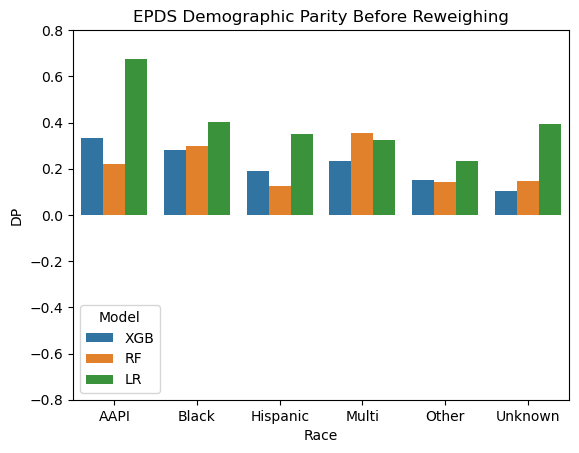

In [54]:
sns.barplot(data=no_reweigh_results, x='Race', y='DP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS Demographic Parity Before Reweighing')
plt.savefig('No Reweigh DP.png',dpi=600)

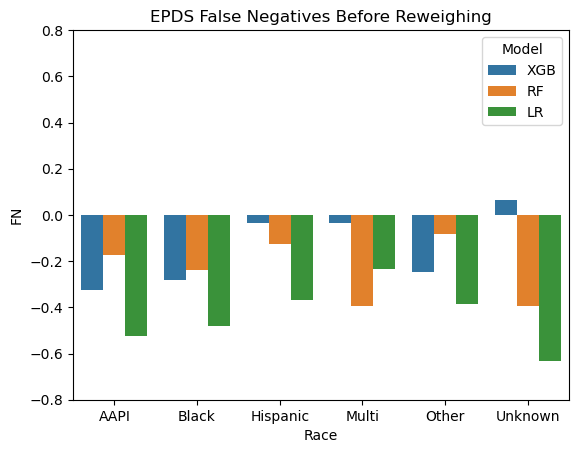

In [55]:
sns.barplot(data=no_reweigh_results, x='Race', y='FN', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS False Negatives Before Reweighing')
plt.savefig('No Reweigh FN.png',dpi=600)

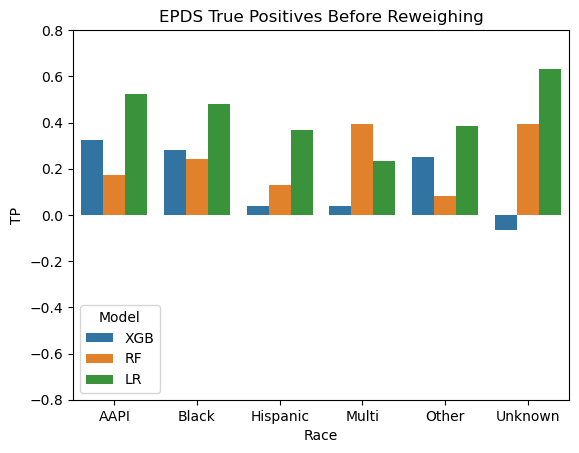

In [56]:
sns.barplot(data=no_reweigh_results, x='Race', y='TP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS True Positives Before Reweighing')
plt.savefig('No Reweigh TP.png',dpi=600)

## With Reweighing

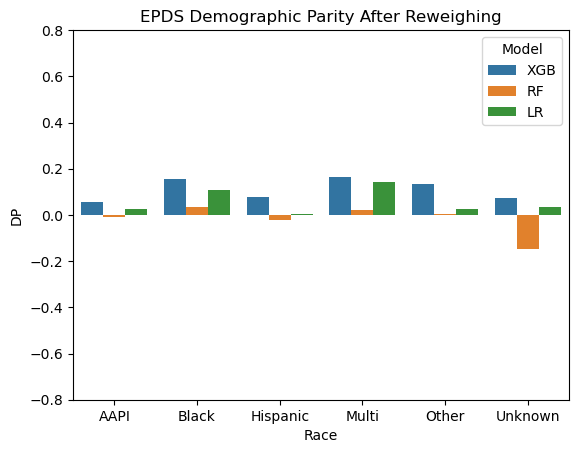

In [57]:
sns.barplot(data=reweigh_results, x='Race', y='DP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS Demographic Parity After Reweighing')
plt.savefig('Reweigh DP.png',dpi=600)

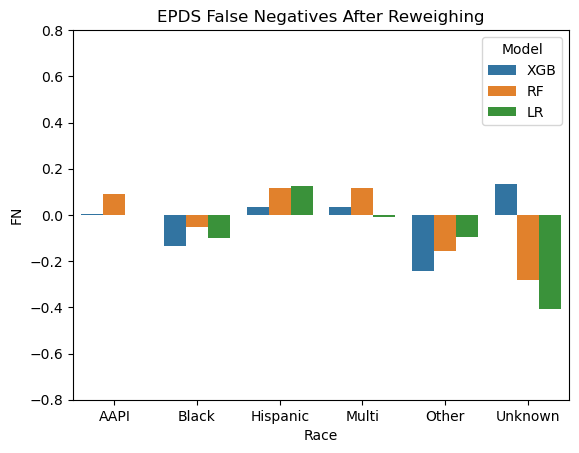

In [58]:
sns.barplot(data=reweigh_results, x='Race', y='FN', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS False Negatives After Reweighing')
plt.savefig('Reweigh FN.png',dpi=600)

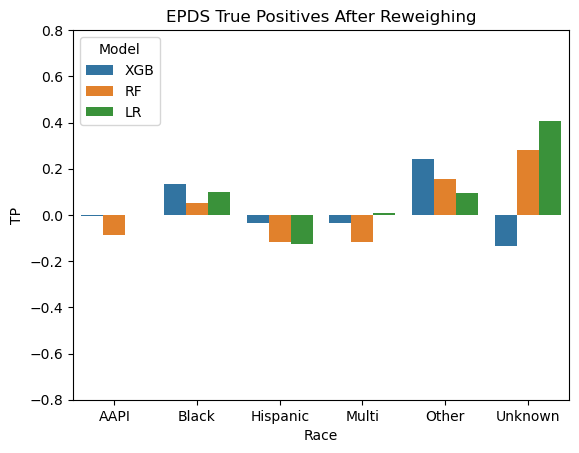

In [59]:
sns.barplot(data=reweigh_results, x='Race', y='TP', hue='Model')
plt.ylim((-0.8,0.8))
plt.title('EPDS True Positives After Reweighing')
plt.savefig('Reweigh TP.png',dpi=600)

In [62]:
# save this file and output as html
import os
os.system('jupyter nbconvert --to html data_analysis_EPDS.ipynb')

[NbConvertApp] Converting notebook data_analysis_EPDS.ipynb to html
[NbConvertApp] Writing 1802563 bytes to data_analysis_EPDS.html


0

In [61]:
X_train.to_excel("X_train.xlsx")
y_train.to_excel("y_train.xlsx")
X_test.to_excel("X_test.xlsx")
y_test.to_excel("y_test.xlsx")